In [3]:
import time
import os
import torch
import pytorch_mask_rcnn as pmr


# ------------------ adjustable parameters ---------------------

use_cuda = True # choose to use GPU or not
visualize = True # choose to visualize evaluation results or not
evaluation = False # choose to compute the AP or not
val_num_samples = 10 # number of samples during test
dataset = 'voc' # coco or voc
data_dir = 'E:/PyTorch/data/VOC2012' # dataset directory
num_classes = 21 # 91 for coco, 21 for voc
ckpt_path = '../checkpoint_voc.pth' # path where to save the checkpoint.pth

# ------------------ adjustable parameters ---------------------

device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
print('cuda: {}\nuse_cuda: {}\n{} GPU(s) available'.format(torch.cuda.is_available(), use_cuda, torch.cuda.device_count()))
print('\ndevice: {}'.format(device))

valset = pmr.datasets(dataset, data_dir, 'val', True, device=device)
classes = valset.classes
if evaluation:
    if dataset == 'voc':
        valset.convert_to_coco_format()
    coco = valset.coco
    iou_types = ['bbox', 'segm']
    coco_evaluator = pmr.CocoEvaluator(coco, iou_types)

indices = torch.randperm(len(valset)).tolist()
valset = torch.utils.data.Subset(valset, indices[:val_num_samples])

model = pmr.maskrcnn_resnet50(True, num_classes).to(device)

if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    
    del checkpoint
    torch.cuda.empty_cache()

cuda: True
use_cuda: True
1 GPU(s) available

device: cuda


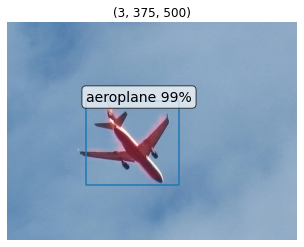

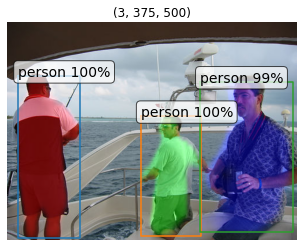

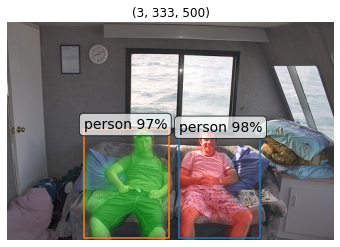

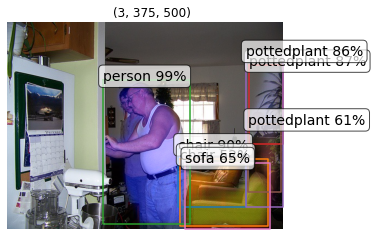

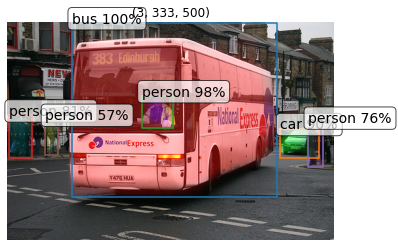

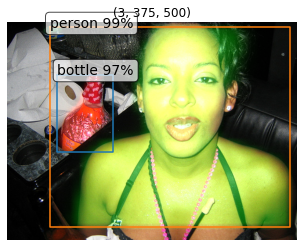

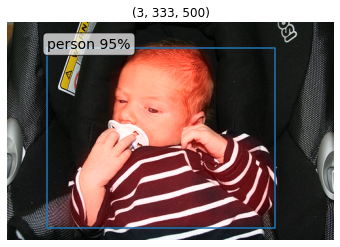

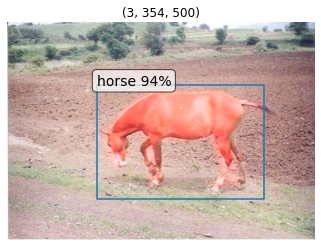

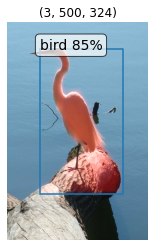

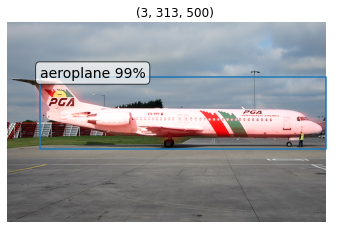


total time: 5.20 s


In [4]:
since = time.time()

# ------------------ test ---------------------

model.eval()
for (image, target) in valset:
    with torch.no_grad():
        result = model(image)

    if evaluation:
        result = {k: v.cpu() for k, v in result.items()}
        res = {target['image_id'].item(): result}
        coco_evaluator.update(res)

    if visualize:
        #print('  '.join(classes[l.item()] for l in result['labels']))
        #print('  '.join('{:.2f}'.format(p) for p in result['scores']))
        pmr.show(image, result, classes)

if evaluation:
    coco_evaluator.synchronize_between_processes()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()

# ------------------ test ---------------------

print('\ntotal time: {:.2f} s'.format(time.time() - since))